In [1]:
import Pkg
Pkg.add("Revise")
Pkg.add("IonSim")
Pkg.add("QuantumOptics")
Pkg.add("StochasticDiffEq")
Pkg.add("DSP")
using PyPlot
using Revise
using IonSim
using QuantumOptics: timeevolution, stochastic, Basis

   Resolving package versions...
  No Changes to `C:\Users\jewoo\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\jewoo\.julia\environments\v1.10\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\jewoo\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\jewoo\.julia\environments\v1.10\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\jewoo\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\jewoo\.julia\environments\v1.10\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\jewoo\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\jewoo\.julia\environments\v1.10\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\jewoo\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\jewoo\.julia\environments\v1.10\Manifest.toml`


In [2]:
C = Ca40([("S1/2", -1/2, "g"),("D5/2", -1/2, "e")])
# Create aliases for the qubit states for easier access
#set_sublevel_alias!(C, Dict("g" => ("S1/2", -1/2), "e" => ("D5/2", -1/2)))

# Define the trap configuration. We'll model a single ion in a linear chain
# with a 1 MHz axial motional frequency.
chain = LinearChain(
    ions=[C],
    comfrequencies=(x=3e6, y=3e6, z=1e6),   
    selectedmodes=(;z=[1]) # We only consider the axial mode of motion
)

# Define the laser that will drive the transition
L = Laser()

# Combine all components into a single Trap object, which represents the full experiment
# This is the main object that holds the entire state of our physical system.
T = Chamber(
    iontrap=chain,
    B=0.37e-3,              # Magnetic field in Tesla
    #δB = 0.1,
    Bhat=ẑ,              # Magnetic field direction
    lasers=[L]
)

polarization!(L, (x̂ - ẑ)/√2)
wavevector!(L, (x̂ + ẑ)/√2);
wavelength_from_transition!(L, C, ("g", "e"), T)
intensity_from_pitime!(L, 4e-6, C, ("g", "e"), T);

ion = ions(T)[1]

ψ0_ion_1 = ion["g"]
ψ0_ion_2 = ion[("S1/2", -1/2)]
ψ0_ion_3 = ionstate(ion, "g")

print(ψ0_ion_1)
mode = modes(T)[1]

ψ0_mode_1 = mode[0]
ψ0_mode_2 = fockstate(mode, 0)
ψ0_mode_3 = groundstate(mode)

print(ψ0_mode_1)
ψ₀ = ion["g"] ⊗ mode[0];

Ket(dim=2)
  basis: ⁴⁰Ca
 1.0 + 0.0im
 0.0 + 0.0imKet(dim=11)
  basis: VibrationalMode(ν=1.0e6, axis=ẑ, N=10)
 1.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im

In [3]:
function pulse(T:: Chamber , tspan, pitime)
    # Define the laser that will drive the transition
    L = T.lasers[1]

    # Combine all components into a single Trap object, which represents the full experiment
    # This is the main object that holds the entire state of our physical system.
    
    pi2_time = pitime*1e6/2

    res_intensity = intensity_from_pitime(L, pitime, T.iontrap.ions[1], ("g", "e"), T)

    function intensity_funtion(t)
    if(t<=pi2_time)
        return res_intensity
    elseif(t>=tspan[end] - pi2_time)
        return res_intensity
    else
        return 0.0
    end

    end
    intensity!(L, intensity_funtion)

    function phase_funtion(t)
        if(t<=pi2_time)
            return 2*pi
        elseif(t>=tspan[end] - pi2_time)
            return pi
        else
            return 0.0
        end
    end

    phase!(L, phase_funtion)
    h = hamiltonian(T, timescale=1e-6, rwa_cutoff=Inf);
    return h
end


function experiment(T::Chamber, wait_time)
    pitime = 4e-6
    tspan = 0: 0.1: wait_time+4

    h = pulse(T, tspan, pitime)
    return h
end

# phase!(L, phase_funtion)
# h = hamiltonian(T, timescale=1e-6, rwa_cutoff=Inf);

experiment (generic function with 1 method)

In [4]:
Pkg.add("ProgressMeter")
using Distributions # You'll need to add this package!
using ProgressMeter # For a nice progress bar

   Resolving package versions...
  No Changes to `C:\Users\jewoo\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\jewoo\.julia\environments\v1.10\Manifest.toml`


In [5]:


# --- 2. Define Noise Parameters from the Paper ---
const N_shots = 200  # Number of experiments to average over. More is better.
B_rms_shielded = 2.7e-6  # (T) The final shielded noise from the paper
B_rms_unshielded = 2.7e-5 # (T) Example for 20 dB worse noise

# Create the Gaussian distribution for the magnetic field noise
# This replaces your B_span!
noise_distribution = Normal(0, B_rms_shielded)


# --- 3. Function to run ONE shot of a Ramsey experiment ---
# This function takes a specific, constant δB for a single shot
function run_ramsey_shot(t_wait, δB_shot)
    # The Chamber is now inside the function, as δB changes each time
    L = Laser()
    T = Chamber(
        iontrap=chain,
        B=0.37e-3,
        δB=δB_shot, # Use the random δB for this shot
        Bhat=ẑ,
        lasers=[L]
    )
    polarization!(L, (x̂ - ẑ)/√2)
    wavevector!(L, (x̂ + ẑ)/√2);
    wavelength_from_transition!(L, C, ("g", "e"), T)

    # Ramsey sequence: π/2 pulse, wait, π/2 pulse
    tspan = 0:0.1:t_wait*1e6
    h = pulse(T, tspan, 4e-6)
    tout, sol = timeevolution.schroedinger_dynamic(tspan, ψ₀, h)
    # Note: Rabi frequency and pulse times are illustrative
    # Ω = 2π * 50e3
    # τ_π_half = π / (2Ω)

    # # First π/2 pulse
    # _, sol_1 = timeevolution.schroedinger_dynamic(0:0.01e-6:τ_π_half, ψ₀, h)
    # ψ_after_pulse1 = last(sol_1)

    # # Wait time (free evolution)
    # # During the wait, only the base Hamiltonian h affects the ion
    # _, sol_wait = timeevolution.schroedinger_dynamic(0:0.01e-6:t_wait, ψ_after_pulse1, h)
    # ψ_after_wait = last(sol_wait)

    # # Second π/2 pulse
    # _, sol_2 = timeevolution.schroedinger_dynamic(0:0.01e-6:τ_π_half, ψ_after_wait, h)
    # ψ_final = last(sol_2)

    # Return the final probability of being in the 'g' state
    return expect(ionprojector(T, "g"), sol[end])
end


# --- 4. Main Simulation Loop (Ensemble Average) ---
function simulate_decoherence()
    wait_times = 1e-5:5e-6:3e-3 # Simulate for 300 ms, as in the paper's Ramsey fig
    avg_g_population = []

    @showprogress "Simulating Ramsey Fringes..." for t in wait_times
        final_pops_for_t = zeros(N_shots)
        for i in 1:N_shots
            # For each shot, draw a NEW random magnetic field offset
            δB_shot = rand(noise_distribution)
            final_pops_for_t[i] = run_ramsey_shot(t, δB_shot)
        end
        # Average the results from all shots for this wait time
        push!(avg_g_population, real(sum(final_pops_for_t) / N_shots))
        # println("Wait time $(t*1e3) ms: Avg. g-pop = $(avg_g_population)")
    end
    return wait_times, avg_g_population
end



simulate_decoherence (generic function with 1 method)

Running simulation with SHIELDED noise (B_rms = 2.7e-6 T)


Simulating Ramsey Fringes... 100%|███████████████████████| Time: 1:11:36


1.0e-5:5.0e-6:0.003
Any[0.8586295143049876, 0.7269258887310244, 0.6285255362879971, 0.5286933702814919, 0.5189028012866914, 0.5374752556438779, 0.5062529499739677, 0.5208246917448992, 0.4809611205982477, 0.49926146302158636, 0.4902652613399872, 0.47571297994637085, 0.5376751630900638, 0.49423985353513233, 0.4726574727031705, 0.5161658944214049, 0.4504219745632236, 0.48612032651607806, 0.4783285266991439, 0.4522401716693301, 0.4657923687977161, 0.5396183845769713, 0.5432532773778679, 0.5520944684581515, 0.5223530652276565, 0.5427032943938516, 0.5088481600365112, 0.5160916861359159, 0.5007336349595252, 0.5052357986272252, 0.5011065637400904, 0.47341272166975784, 0.5468516394077626, 0.4987546080269012, 0.5289873091268895, 0.48964354340520977, 0.4430802481778172, 0.5002491505189891, 0.5130539352750393, 0.49515483551402717, 0.5144852786444725, 0.48967215596350583, 0.5088820562656619, 0.48186816938501364, 0.5259705476482103, 0.5080140713268612, 0.5115573487336438, 0.49022658996962176, 0.5052

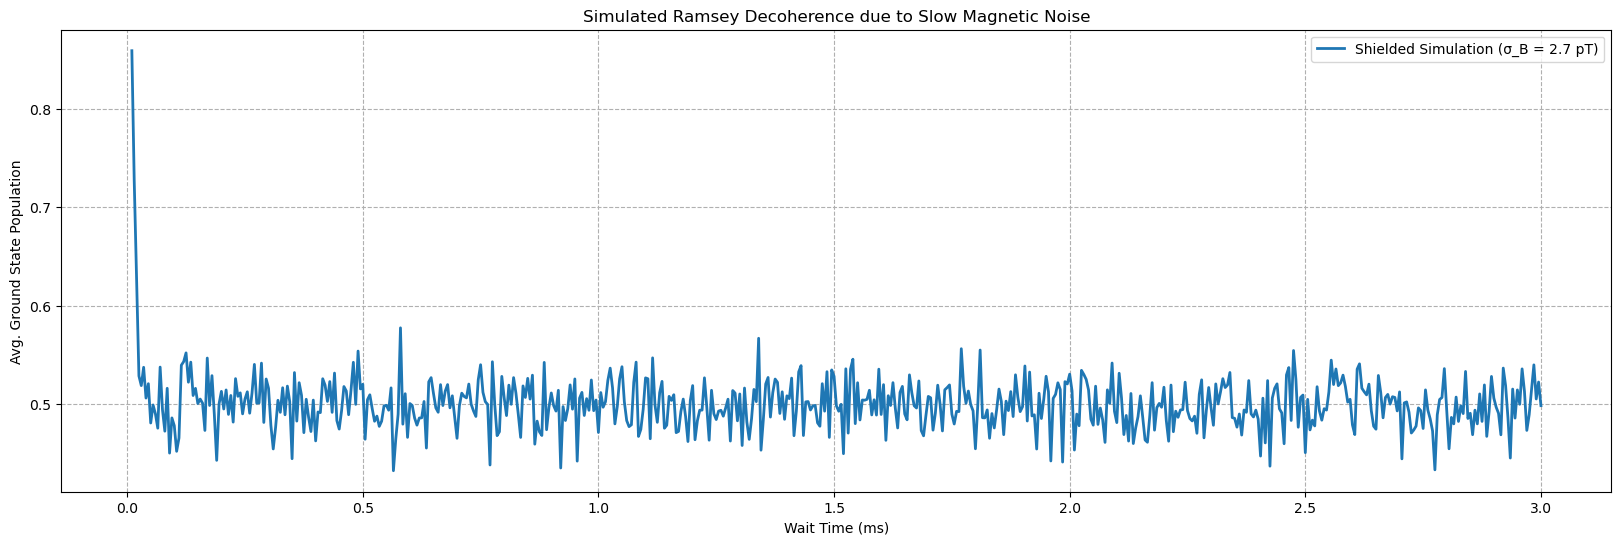

sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


In [6]:
# --- 5. Run and Plot ---
println("Running simulation with SHIELDED noise (B_rms = $B_rms_shielded T)")
times, pops = simulate_decoherence()
println(times)
println(pops)

# You can re-run with the unshielded value to compare!
# noise_distribution = Normal(0, B_rms_unshielded)
# println("Running simulation with UNSHIELDED noise (B_rms = $B_rms_unshielded T)")
# times_unshielded, pops_unshielded = simulate_decoherence()

figure(figsize=(20, 6))
plot(times * 1e3, pops, label="Shielded Simulation (σ_B = 2.7 pT)", linewidth=2)
# plot(times_unshielded * 1e3, pops_unshielded, label="Unshielded Simulation (σ_B = 27 pT)", linewidth=2)

xlabel("Wait Time (ms)")
ylabel("Avg. Ground State Population")
#ylim(0, 1e-11)
title("Simulated Ramsey Decoherence due to Slow Magnetic Noise")
grid(true, linestyle="--")
legend()
show()
display(gcf())

In [19]:
#  --- 1. System Setup (similar to your code) ---
# C = Ca40()
# chain = LinearChain(
#     ions=[C],
#     com_frequencies=(x=2e6, y=2e6, z=1e6),
#     vibrational_modes=(x=[1], y=[1], z=[1])
# )
# ψ₀ = product_state(C, "g")

# --- 2. Define Noise Parameters from the Paper ---
const N_shots = 200  # Number of experiments to average over. More is better.
B_rms_shielded = 2.7e-9  # (T) The final shielded noise from the paper
B_rms_unshielded = 2.7e-5 # (T) Example for 20 dB worse noise

# Create the Gaussian distribution for the magnetic field noise
# This replaces your B_span!
noise_distribution = Normal(0, B_rms_shielded)


# --- 3. Function to run ONE shot of a Ramsey experiment ---
# This function takes a specific, constant δB for a single shot
function run_ramsey_shot(t_wait, δB_shot)
    # The Chamber is now inside the function, as δB changes each time
    L = Laser()
    T = Chamber(
        iontrap=chain,
        B=0.37e-3,
        δB=δB_shot, # Use the random δB for this shot
        Bhat=ẑ,
        lasers=[L]
    )
    polarization!(L, (x̂ - ẑ)/√2)
    wavevector!(L, (x̂ + ẑ)/√2);
    wavelength_from_transition!(L, C, ("g", "e"), T)

    # Ramsey sequence: π/2 pulse, wait, π/2 pulse
    tspan = 0:0.1:t_wait*1e6
    h = pulse(T, tspan, 4e-6)
    tout, sol = timeevolution.schroedinger_dynamic(tspan, ψ₀, h)
    # Note: Rabi frequency and pulse times are illustrative
    # Ω = 2π * 50e3
    # τ_π_half = π / (2Ω)

    # # First π/2 pulse
    # _, sol_1 = timeevolution.schroedinger_dynamic(0:0.01e-6:τ_π_half, ψ₀, h)
    # ψ_after_pulse1 = last(sol_1)

    # # Wait time (free evolution)
    # # During the wait, only the base Hamiltonian h affects the ion
    # _, sol_wait = timeevolution.schroedinger_dynamic(0:0.01e-6:t_wait, ψ_after_pulse1, h)
    # ψ_after_wait = last(sol_wait)

    # # Second π/2 pulse
    # _, sol_2 = timeevolution.schroedinger_dynamic(0:0.01e-6:τ_π_half, ψ_after_wait, h)
    # ψ_final = last(sol_2)

    # Return the final probability of being in the 'g' state
    return expect(ionprojector(T, "g"), sol[end])
end


# --- 4. Main Simulation Loop (Ensemble Average) ---
function simulate_decoherence()
    wait_times = 8e-6:1e-2:5e-1 # Simulate for 300 ms, as in the paper's Ramsey fig
    avg_g_population = []

    @showprogress "Simulating Ramsey Fringes..." for t in wait_times
        final_pops_for_t = zeros(N_shots)
        for i in 1:N_shots
            # For each shot, draw a NEW random magnetic field offset
            δB_shot = rand(noise_distribution)
            final_pops_for_t[i] = run_ramsey_shot(t, δB_shot)
        end
        # Average the results from all shots for this wait time
        push!(avg_g_population, real(sum(final_pops_for_t) / N_shots))
        # println("Wait time $(t*1e3) ms: Avg. g-pop = $(avg_g_population)")
    end
    return wait_times, avg_g_population
end



simulate_decoherence (generic function with 2 methods)

In [ ]:
# --- 5. Run and Plot ---
println("Running simulation with SHIELDED noise (B_rms = $B_rms_shielded T)")
times, pops = simulate_decoherence()
println(times)
println(pops)

# You can re-run with the unshielded value to compare!
# noise_distribution = Normal(0, B_rms_unshielded)
# println("Running simulation with UNSHIELDED noise (B_rms = $B_rms_unshielded T)")
# times_unshielded, pops_unshielded = simulate_decoherence()

figure(figsize=(20, 6))
plot(times * 1e3, pops, label="Shielded Simulation (σ_B = 2.7 pT)", linewidth=2)
# plot(times_unshielded * 1e3, pops_unshielded, label="Unshielded Simulation (σ_B = 27 pT)", linewidth=2)

xlabel("Wait Time (ms)")
ylabel("Avg. Ground State Population")
#ylim(0, 1e-11)
title("Simulated Ramsey Decoherence due to Slow Magnetic Noise")
grid(true, linestyle="--")
legend()
show()
display(gcf())

Running simulation with SHIELDED noise (B_rms = 2.7e-9 T)


Simulating Ramsey Fringes...  20%|█████                  |  ETA: 6:57:07

In [9]:
#  --- 1. System Setup (similar to your code) ---
# C = Ca40()
# chain = LinearChain(
#     ions=[C],
#     com_frequencies=(x=2e6, y=2e6, z=1e6),
#     vibrational_modes=(x=[1], y=[1], z=[1])
# )
# ψ₀ = product_state(C, "g")

# --- 2. Define Noise Parameters from the Paper ---
const N_shots = 200  # Number of experiments to average over. More is better.
B_rms_1 = 1e-6  # (T) The final shielded noise from the paper
B_rms_2 = 2e-6 # (T) Example for 20 dB worse noise
B_rms_3 = 3e-6 # (T) Example for 20 dB worse noise

# Create the Gaussian distribution for the magnetic field noise
# This replaces your B_span!
noise_distribution_1 = Normal(0, B_rms_1)
noise_distribution_2 = Normal(0, B_rms_2)
noise_distribution_3 = Normal(0, B_rms_3)


# --- 3. Function to run ONE shot of a Ramsey experiment ---
# This function takes a specific, constant δB for a single shot
function run_ramsey_shot(t_wait, δB_shot)
    # The Chamber is now inside the function, as δB changes each time
    L = Laser()
    T = Chamber(
        iontrap=chain,
        B=0.37e-3,
        δB=δB_shot, # Use the random δB for this shot
        Bhat=ẑ,
        lasers=[L]
    )
    polarization!(L, (x̂ - ẑ)/√2)
    wavevector!(L, (x̂ + ẑ)/√2);
    wavelength_from_transition!(L, C, ("g", "e"), T)

    # Ramsey sequence: π/2 pulse, wait, π/2 pulse
    tspan = 0:0.1:t_wait*1e6
    h = pulse(T, tspan, 4e-6)
    tout, sol = timeevolution.schroedinger_dynamic(tspan, ψ₀, h)
    # Note: Rabi frequency and pulse times are illustrative
    # Ω = 2π * 50e3
    # τ_π_half = π / (2Ω)

    # # First π/2 pulse
    # _, sol_1 = timeevolution.schroedinger_dynamic(0:0.01e-6:τ_π_half, ψ₀, h)
    # ψ_after_pulse1 = last(sol_1)

    # # Wait time (free evolution)
    # # During the wait, only the base Hamiltonian h affects the ion
    # _, sol_wait = timeevolution.schroedinger_dynamic(0:0.01e-6:t_wait, ψ_after_pulse1, h)
    # ψ_after_wait = last(sol_wait)

    # # Second π/2 pulse
    # _, sol_2 = timeevolution.schroedinger_dynamic(0:0.01e-6:τ_π_half, ψ_after_wait, h)
    # ψ_final = last(sol_2)

    # Return the final probability of being in the 'g' state
    return expect(ionprojector(T, "g"), sol[end])
end


# --- 4. Main Simulation Loop (Ensemble Average) ---
function simulate_decoherence(noise_distribution)
    wait_times = 8e-6:1e-6:1e-4 # Simulate for 300 ms, as in the paper's Ramsey fig
    avg_g_population = []

    @showprogress "Simulating Ramsey Fringes..." for t in wait_times
        final_pops_for_t = zeros(N_shots)
        for i in 1:N_shots
            # For each shot, draw a NEW random magnetic field offset
            δB_shot = rand(noise_distribution)
            final_pops_for_t[i] = run_ramsey_shot(t, δB_shot)
        end
        # Average the results from all shots for this wait time
        push!(avg_g_population, real(sum(final_pops_for_t) / N_shots))
        # println("Wait time $(t*1e3) ms: Avg. g-pop = $(avg_g_population)")
    end
    return wait_times, avg_g_population
end



simulate_decoherence (generic function with 2 methods)

Running simulation with various noise (B_rms = 1e-6, 2e-6, 3e-6)


Simulating Ramsey Fringes... 100%|███████████████████████| Time: 0:01:44
Simulating Ramsey Fringes... 100%|███████████████████████| Time: 0:01:46
Simulating Ramsey Fringes... 100%|███████████████████████| Time: 0:01:52


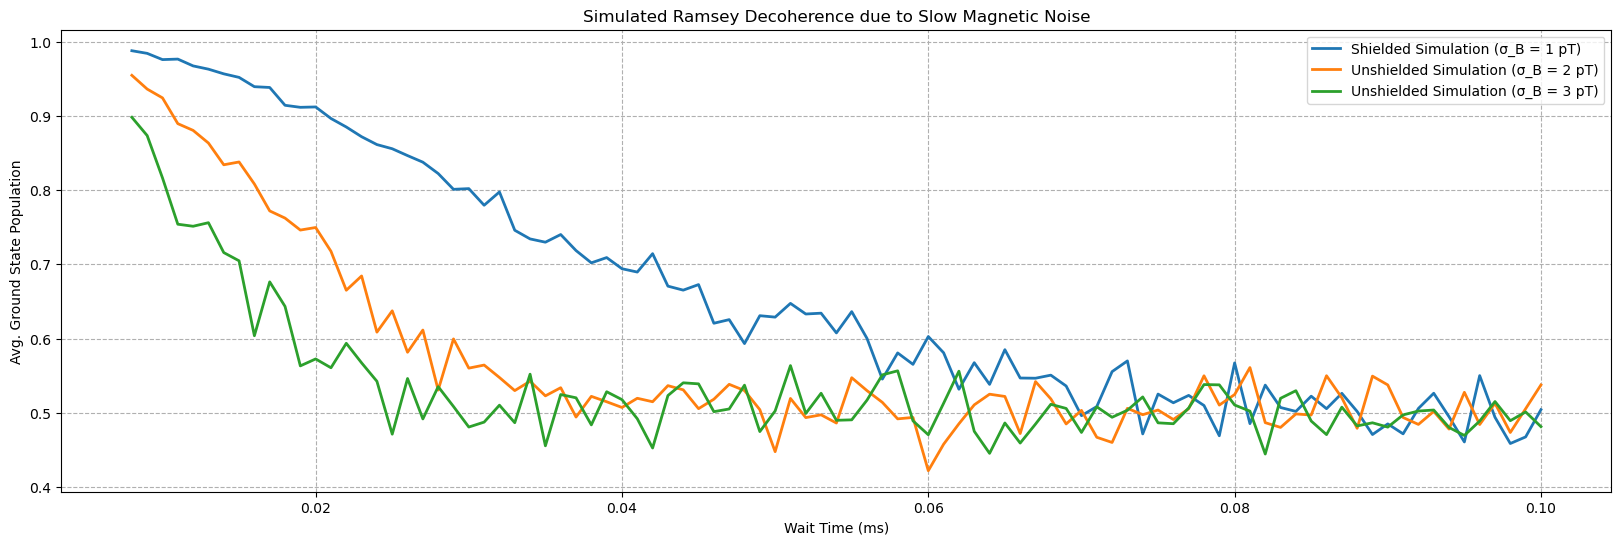

In [10]:
# --- 5. Run and Plot ---
println("Running simulation with various noise (B_rms = 1e-6, 2e-6, 3e-6)")
times_1, pops_1 = simulate_decoherence(noise_distribution_1)
times_2, pops_2 = simulate_decoherence(noise_distribution_2)
times_3, pops_3 = simulate_decoherence(noise_distribution_3)

# You can re-run with the unshielded value to compare!
# noise_distribution = Normal(0, B_rms_unshielded)
# println("Running simulation with UNSHIELDED noise (B_rms = $B_rms_unshielded T)")
# times_unshielded, pops_unshielded = simulate_decoherence()

figure(figsize=(20, 6))
plot(times_1 * 1e3, pops_1, label="Shielded Simulation (σ_B = 1 pT)", linewidth=2)
plot(times_2 * 1e3, pops_2, label="Unshielded Simulation (σ_B = 2 pT)", linewidth=2)
plot(times_3 * 1e3, pops_3, label="Unshielded Simulation (σ_B = 3 pT)", linewidth=2)

xlabel("Wait Time (ms)")
ylabel("Avg. Ground State Population")
#ylim(0, 1e-11)
title("Simulated Ramsey Decoherence due to Slow Magnetic Noise")
grid(true, linestyle="--")
legend()
show()
display(gcf())

Running simulation with various noise (B_rms = 1e-6, 2e-6, 3e-6)


Simulating Ramsey Fringes... 100%|███████████████████████| Time: 0:01:38
Simulating Ramsey Fringes... 100%|███████████████████████| Time: 0:01:43
Simulating Ramsey Fringes... 100%|███████████████████████| Time: 0:01:49


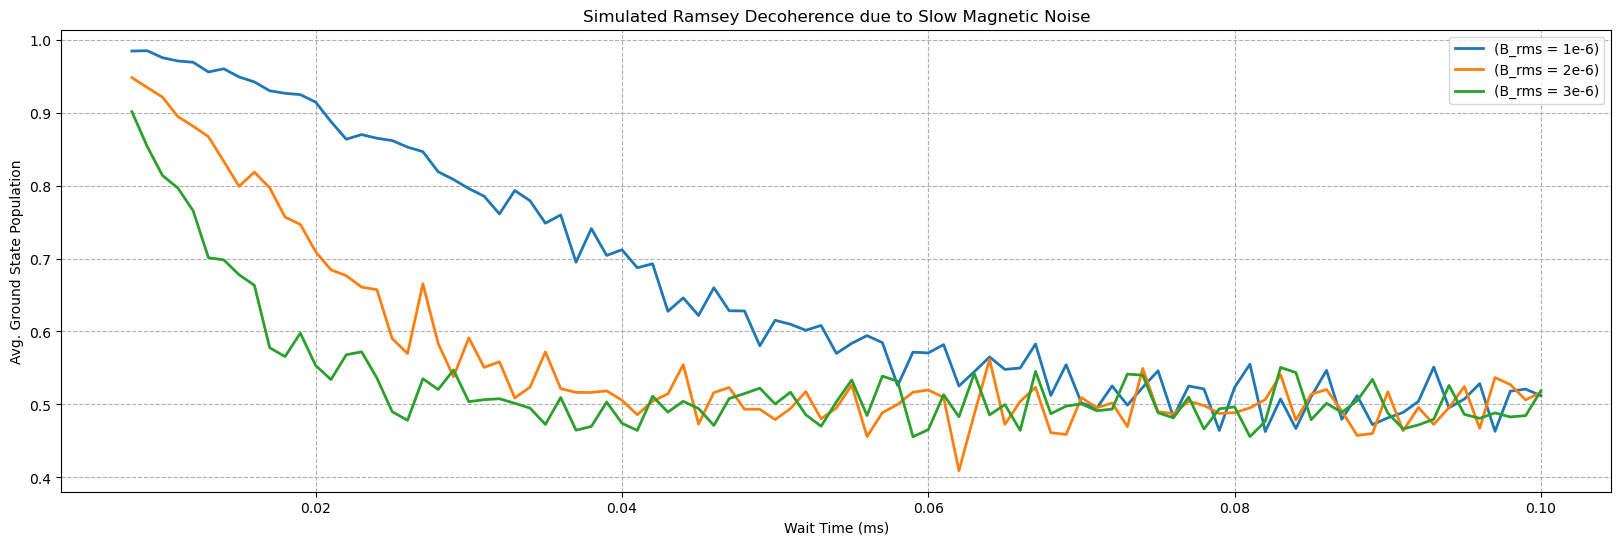

In [11]:
# --- 5. Run and Plot ---
println("Running simulation with various noise (B_rms = 1e-6, 2e-6, 3e-6)")
times_1, pops_1 = simulate_decoherence(noise_distribution_1)
times_2, pops_2 = simulate_decoherence(noise_distribution_2)
times_3, pops_3 = simulate_decoherence(noise_distribution_3)

# You can re-run with the unshielded value to compare!
# noise_distribution = Normal(0, B_rms_unshielded)
# println("Running simulation with UNSHIELDED noise (B_rms = $B_rms_unshielded T)")
# times_unshielded, pops_unshielded = simulate_decoherence()

figure(figsize=(20, 6))
plot(times_1 * 1e3, pops_1, label="(B_rms = 1e-6)", linewidth=2)
plot(times_2 * 1e3, pops_2, label="(B_rms = 2e-6)", linewidth=2)
plot(times_3 * 1e3, pops_3, label="(B_rms = 3e-6)", linewidth=2)

xlabel("Wait Time (ms)")
ylabel("Avg. Ground State Population")
#ylim(0, 1e-11)
title("Simulated Ramsey Decoherence due to Slow Magnetic Noise")
grid(true, linestyle="--")
legend()
show()
display(gcf())